In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pylab as plt
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy
from astropy.wcs import WCS
from astropy.io import fits
from astropy.modeling import models
from astropy import units as u

from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.fitting import fit_generic_continuum

from readmultispec import readmultispec #https://github.com/kgullikson88/General/blob/master/readmultispec.py
import eqwidth

from scipy.stats import norm


from glob import glob
import os
import re


%matplotlib inline

In [2]:
#Reads in the spectra files
working_dir_path = '/Users/aylingarcias/Year1/OSMOS_oct/spectra/' #where I want my output to go
globpath = os.path.join(working_dir_path, '/Users/aylingarcias/Year1/OSMOS_oct/reduceddata/d*.fits') #where the spectra is
filelist = glob(globpath)
filelist.sort()
print (len(filelist)) #how many files

#reading spectra
readFITSfile = readmultispec(filelist[1]) #picking the second file, this arbitrary

# header
readFITSfile['header']

#exposure time
# readFITSfile['header']['EXPTIME'] #the first thing brakets emphasizes the header, and the second thing is what keyword

32
Dispersion is linear
/Users/aylingarcias/Year1/OSMOS_oct/reduceddata/daa0068.fits


SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3 / Number of axes                                 
NAXIS1  =                 4136 / Axis length                                    
NAXIS2  =                    1 / Axis length                                    
NAXIS3  =                    4 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2019-12-03T18:58:47' / Date FITS file was generated                  
IRAF-TLM= '2019-12-03T18:58:47' / Time of last modification                     
OBJECT  = '2M20381609'         / Name of the object observed                    
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics',

## Taking a Look at the Spectra

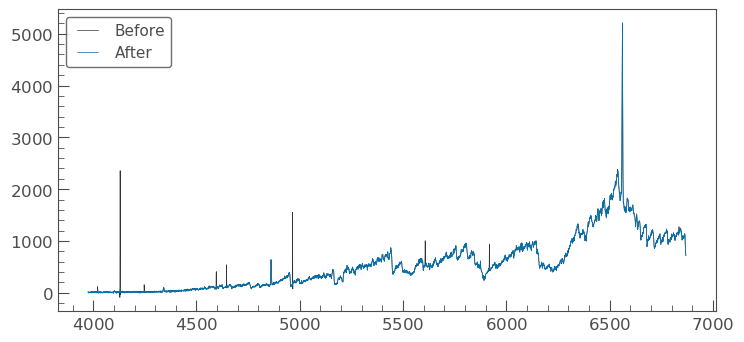

In [12]:
#flux has four dimensions which stands for

# BANDID1 = 'spectrum - optimally extracted'
# BANDID2 = 'spectrum - straight sum'
# BANDID3 = 'sky background'
# BANDID4 = 'sigma   '

#remember 1 is 0 in python
wave = readFITSfile['wavelen'] #wavelength , also note it's not technically found in header
flux = readFITSfile['flux'][0] #flux , bandid1, also note it's not technically found in header
flux_err = readFITSfile['flux'][3] #flux error, bandid4, also note it's not technically found in header

#trying to pick the right flux
plt.plot(wave,readFITSfile['flux'][1],label="Before") 
plt.plot(wave,flux,label="After") #already called flux, so no need to worry about using the right one
plt.legend()

## Fitting the Halpha-Line -- SINGLE OBJECT (TEST)
Try changing the fitting code to use something more common like curve-fit.

1. Make a smaller range of values: reduced wavelength array, flux array and flux error array to region. SO from halpha wavelength-100 angstroms to halpha wavelength+100 angstroms. This is the orange in the top plot.

2. Fit the continuum within this new region a different gaussian that shouldn't fit the halpha line. This the blue in the top plot.

3. Normalize the spectrum by dividing it by the continuum fit (the fit is like a function; gives you y-axis values), because halpha is onto of continuum and we want to flatten it (see second plot)

4. Fit the halpha within this smaller and flatten region with a gaussians. 

5. Use equation to find radial velocity, which will be later used to shift spectra.

6561.013577545198
velocity: -82.06135490286655 km / s


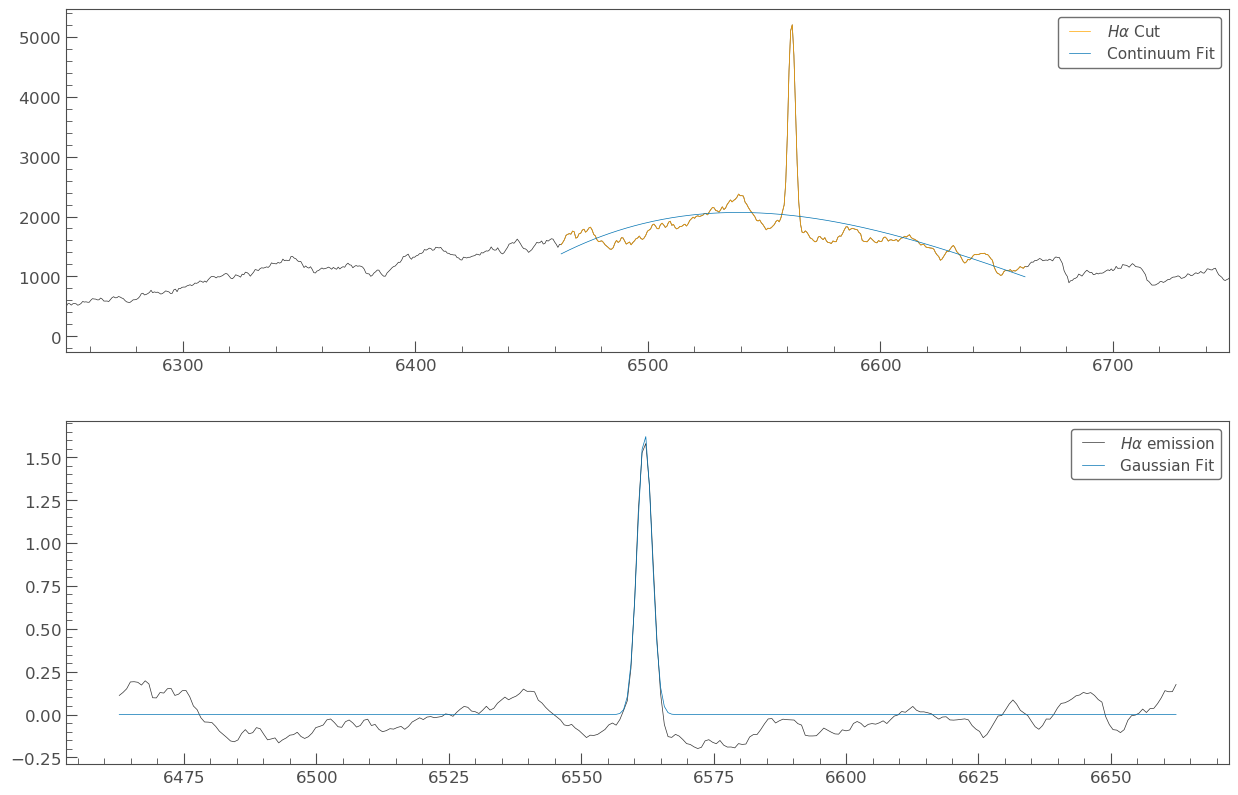

In [13]:
fig, ax = plt.subplots(2,figsize=(15,10))

## EQUATION TO MEASURE RADIAL VELOCITIES
def mea_vel(w2,w1):
    c = 299792 *(u.km/u.s) #km/s
    return (c*(w2-w1)/w1) #w2 = observed halpha and w1 = measure halpha

#---------------------------------------------------------------------------------------------------------------------------------#

## MAKING SMALLER ARRAYS/REGIONS
#cut the data to focus on h-alpha subregion, subregion to id halpha, fit better
mean0 = 6562.81 #halpha lab wavelength
minx=mean0-100. #defines minimum value of new region 
maxx=mean0+100. #defines maximum value of new region 

#defining the subregions. e.g. fluxcut: use the flux where the a condition is true to where the b condition is true --> flux[a:b]
sub_wave_c = np.linspace(minx,maxx,len(wave)) #h-alpha subregion, x-axis
fluxcut = flux[np.argmin(np.abs((wave)-np.min(sub_wave_c))):np.argmin(np.abs((wave)-np.max(sub_wave_c)))] #flux cut
fluxcut_err = flux_err[np.argmin(np.abs((wave)-np.min(sub_wave_c))):np.argmin(np.abs((wave)-np.max(sub_wave_c)))] #wave cut
wavecut = wave[np.argmin(np.abs((wave)-np.min(sub_wave_c))):np.argmin(np.abs((wave)-np.max(sub_wave_c)))] #wave cut

#---------------------------------------------------------------------------------------------------------------------------------#

## FITTING THE CONTINUUM
#intial inputs to continuum fit, guassian parameters
mean = wavecut[np.argmax(fluxcut)] #it is finding the mean, or the wavelength where we have the peak of the halpha line
stddev = 1. #can be changed to something larger

#fitting the continuum with the specutils package, see: https://specutils.readthedocs.io/en/stable/fitting.html
spectrum_c = Spectrum1D(flux=fluxcut*u.Jy, spectral_axis=wavecut*0.1*u.nm) #note that there is no units for flux yet, just had to add Jy to stop from spitting error
g1_fit = fit_generic_continuum(spectrum_c)
y_continuum_fitted = g1_fit(wavecut*0.1*u.nm) #length of fit is the same as wavelength array

#first plot, shows full spectra, the shorter region in orange, and the fit to the continuum.
ax[0].plot(wave, flux)
ax[0].plot(wavecut, fluxcut,color='orange',label=r"$H\alpha$ Cut")
ax[0].plot(wavecut,y_continuum_fitted,label="Continuum Fit")
ax[0].legend()
ax[0].set_xlim(6250,6750)

# We normalize the continuum by  dividing it by the continuum fit.
spec_norm = (spectrum_c / y_continuum_fitted) - 1.

#---------------------------------------------------------------------------------------------------------------------------------#

## NOW ONTO THE HALPHA LINE 
# We normalize the flux by dividing it by the continuum fit
norm_flux = (fluxcut*u.Jy/ y_continuum_fitted) - 1. # initial guesses 
amp = np.max(norm_flux) # initial guess for the peak of the normalize flux

#creating a subregion around Halpha to fit the actual line 
sub_region = SpectralRegion((mean-10.)*0.1*u.nm, (mean+10.)*0.1*u.nm)
sub_spectrum = extract_region(spec_norm, sub_region) #subspectrum from that subregion

#fitting the h-alpha emission line, see: https://specutils.readthedocs.io/en/stable/fitting.html
g_init = models.Gaussian1D(amplitude=amp, mean=mean*0.1*u.nm, stddev=stddev*0.1*u.nm)
g_fit = fit_lines(sub_spectrum, g_init)
y_fit = g_fit(wavecut*0.1*u.nm) #producing fit on quantized pixel scale (much more finely sampled wavelength, find wavelength mean of Gaussian fit)

#plotting the normalize graph with the fit of the Halpha line
ax[1].plot(wavecut, norm_flux, label=r"$H\alpha$ emission")
ax[1].plot(wavecut, y_fit, label="Gaussian Fit")
ax[1].legend()

#---------------------------------------------------------------------------------------------------------------------------------#

#finding the mean wavelength
g_fit_mean= estimate_line_parameters(sub_spectrum, models.Gaussian1D()).mean.value*10 #to get fitting parameters
print (g_fit_mean)

#using the radial velocity equation to find the radial velocity. 
print ("velocity:", mea_vel(g_fit_mean,mean0)) 

## Fitting the Halpha-Line -- LOOP (+ Shifting)

So what following is doing is the same as cell above but for more than one object.

1. Make a smaller range of values: reduced wavelength array, flux array and flux error array to region. SO from halpha wavelength-100 angstroms to halpha wavelength+100 angstroms. This is the orange in the top plot.

2. Fit the continuum within this new region a different gaussian that shouldn't fit the halpha line. This the blue in the top plot.

3. Normalize the spectrum by dividing it by the continuum fit (the fit is like a function; gives you y-axis values), because halpha is onto of continuum and we want to flatten it (see second plot)

4. Fit the halpha within this smaller and flatten region with a gaussians. 

5. Use equation to find radial velocity, which will be later used to shift spectra.

Additions: 6. Using the radial velocity measurement to shift the spectra.

In [10]:
working_dir_path3 = '/Users/aylingarcias/Year1/OSMOS_oct/spectra/plots/' #this is where I want my plots

#---------------------------------------------------------------------------------------------------------------------------------#

name = np.loadtxt("/Users/aylingarcias/Year1/OSMOS_oct/reduceddata/SpecKey191006_191012",dtype=str, usecols=8) #change based on SpecKey in Jan or Feb

N= len(name) #number of spectra

#---------------------------------------------------------------------------------------------------------------------------------#

def mea_vel(w2,w1):
    '''
    This equation gives us Radial Velocities
    '''
    c = 299792 #km/s
    return (c*(w2-w1)/w1) #w2 = observed halpha and w1 = measure halpha

def newwave(wave,vel): 
    '''
    This equation is giving us the new values of wavelength, i.e. this shifting the spectra
    '''
    c = 299792 #km/s
    return wave*(1-(vel/c))

#---------------------------------------------------------------------------------------------------------------------------------#

#for loop that makes plots for the spectra and then 
vel = []
nwave = []
for i in range (N):
    readFITSfile = readmultispec(filelist[i]) #Reading the FITS
    wave = readFITSfile['wavelen'] #taking the wavelength observed from FITS
    flux = readFITSfile['flux'][0] #taking the flux observed from FITS
    flux_err = readFITSfile['flux'][3] #taking the flux error observed from FITS

    #plotting the spectra
    plt.plot(wave,flux) 
    #saving the figure of the spectra
    plt.savefig(working_dir_path3+'spectra_oct19'+str(name[i])+'.png',bbox_inches='tight') 
    plt.close()

    ## SAME AS ABOVE, MAKING SMALLER ARRAYS/REGIONS
    fig, (ax0,ax1) = plt.subplots(2,figsize=(15,10))
    mean0 = 6562.81 #halpha lab wavelength
    minx=mean0-100. #defines minimum value of new region 
    maxx=mean0+100. #defines maximum value of new region 

    #defining the subregions. e.g. fluxcut: use the flux where the a condition is true to where the b condition is true --> flux[a:b]
    sub_wave_c = np.linspace(minx,maxx,len(wave)) #h-alpha subregion, x-axis
    fluxcut = flux[np.argmin(np.abs((wave)-np.min(sub_wave_c))):np.argmin(np.abs((wave)-np.max(sub_wave_c)))] #flux cut
    wavecut = wave[np.argmin(np.abs((wave)-np.min(sub_wave_c))):np.argmin(np.abs((wave)-np.max(sub_wave_c)))] #wave cut

#---------------------------------------------------------------------------------------------------------------------------------#

    ## FITTING THE CONTINUUM
    #intial inputs to continuum fit, guassian parameters
    mean = wavecut[np.argmax(fluxcut)] #it is finding the mean, or the wavelength where we have the peak of the halpha line
    stddev = 1. #can be changed to something larger

    #fitting the continuum with the specutils package, see: https://specutils.readthedocs.io/en/stable/fitting.html
    spectrum_c = Spectrum1D(flux=fluxcut*u.Jy, spectral_axis=wavecut*0.1*u.nm) #note that there is no units for flux yet, just had to add Jy to stop from spitting error
    g1_fit = fit_generic_continuum(spectrum_c) 
    y_continuum_fitted = g1_fit(wavecut*0.1*u.nm) #length of fit is the same as wavelength array

    #first plot, shows full spectra, the shorter region in orange, and the fit to the continuum.
    ax0.plot(wave, flux,color='black')
    ax0.plot(wavecut, fluxcut,color='orange',label=r"Sub-Continuum Cut")
    ax0.plot(wavecut,y_continuum_fitted,color='blue',label="Continuum Fit")
    ax0.legend()

    # We normalize the continuum by  dividing it by the continuum fit.
    spec_norm = (spectrum_c / y_continuum_fitted) - 1.

#---------------------------------------------------------------------------------------------------------------------------------#

    ## NOW ONTO THE HALPHA LINE 
    # We normalize the flux by dividing it by the continuum fit
    norm_flux = (fluxcut*u.Jy/ y_continuum_fitted) - 1. # initial guesses 
    amp = np.max(norm_flux) # initial guess for the peak of the normalize flux

    #creating a subregion around Halpha to fit the actual line 
    sub_region = SpectralRegion((mean-10.)*0.1*u.nm, (mean+10.)*0.1*u.nm)
    sub_spectrum = extract_region(spec_norm, sub_region) #subspectrum from that subregion

    #fitting the h-alpha emission line, see: https://specutils.readthedocs.io/en/stable/fitting.html
    g_init = models.Gaussian1D(amplitude=amp, mean=mean*0.1*u.nm, stddev=stddev*0.1*u.nm)
    g_fit = fit_lines(sub_spectrum, g_init)
    y_fit = g_fit(wavecut*0.1*u.nm)

    #plotting the normalize graph with the fit of the Halpha line
    ax1.plot(wavecut, norm_flux, label=r"$H\alpha$ emission")
    ax1.plot(wavecut, y_fit, label="Gaussian Fit")
    ax1.legend()
    #saving each figure
    plt.savefig(working_dir_path3+'fit_oct19'+str(name[i])+'.png',bbox_inches='tight')
    plt.close()

    #finding the mean wavelength
    g_fit_mean= estimate_line_parameters(sub_spectrum, models.Gaussian1D()).mean.value*10

    #radial velocities for halpha, equation 1
    vel.append(mea_vel(g_fit_mean,mean0)) 

    #shifted wavelengths, with equation 2. What we use for Halpha Equivalent Widths
    nwave.append(newwave(wave,np.asarray(vel[i]))) 

['2M20381609' '2M20381609' '2M22011310' '2M22464980' '2M22464980'
 '2M22464980' '2M22502051' '2M23025250' '2M23060482' '2M23060482'
 '2M23545147' '2M00243478' '2M00485822' '2M00544803' '2M01015952'
 '2M01034013' '2M01034013' '2M02032864' '2M02032864' '2M18021660'
 '2M18315610' '2M19211305' '2M19510930' '2M19535443' '2M20372081'
 '2M15040626' '2M15163731' '2M15123818' '2M16402068' '2M16402068'
 '2M18154756' '2M18154756']
32
Dispersion is linear
Dispersion is linear


KeyboardInterrupt: 

## Finding Halpha Equivalent Width (Code from Thomas + Elisabeth)

1. We are fitting each data point with a gaussian. The peak is the data point and the wings correspond to the error bars.
2. We are then adding these flux offsets to the flux data in order to caclulate where the centroid should actually be (this will be done to the wavelength information)

In [11]:
def get_offsets(flux, flux_err, steps): #fitting a gaussian to each data point (centroid) and error bars (wings). Makes a lists of offsets from these small gaussian fits
    offsets = np.zeros(shape=(steps, flux.shape[0]))
    for offsetID in range(offsets.shape[0]):
        for binID in range(offsets.shape[1]):
            Err = flux_err[binID]
            offsets[offsetID, binID] = random.gauss(0, Err)
    return offsets 

steps=1000
Halpha_EQ = np.empty(shape=(len(HA_EW), steps))

for rowID in range (N): #finding the equivalent widths of these list of offsets + halpha. This results in a hist that somewhat lookst like normal distribution. Where the centroid should be the actual value of Halpha and the width of the gaussian is the standard deviation.
    readFITSfile = readmultispec(filelist[rowID])
    wave = nwave[rowID]
    flux = readFITSfile['flux'][0]
    flux_err = readFITSfile['flux'][3]
    offsets = get_offsets(flux.astype('float64'),flux_err.astype('float64'), steps)
    for idx, offset in enumerate (offsets):
        newFlux = flux.copy() + offset # flux + error bar
        val = eqwidth.measure_ha(wave,newFlux) #Elisabeth's code to calculate the equivalent widths.
        Halpha_EQ[rowID, idx] = val

Dispersion is linear


KeyboardInterrupt: 

In [ ]:
working_dir_path2='/Users/aylingarcias/Year1/Scripts/TIC_folders/'
HA_EW_final=[]
HA_EW_err=[]

for i in range (N):
    bins_h,bins_l,patch = plt.hist(Halpha_EQ[i, :],density=True) #density gives you the area under the curve = 1
    #bins_h new ydata for gaussian fit and bins_l gives you the left edge of the xaxis
    bins_m=[] #the middle of the bins, new xdata for gaussian fit
    for h in range (len(bins_l)-1):
        bins_m.append((bins_l[h]+bins_l[h+1])/2) #bins centroid

    #fitting gaussian line to hist
    
    new_bins_m=np.linspace(np.min(bins_m),np.max(bins_m),100)
    mu, sigma = norm.fit(Halpha_EQ[i, :])
    best_fit_line = norm.pdf(new_bins_m, mu, sigma)
    plt.plot(new_bins_m, best_fit_line,'-', lw=3, alpha=0.6, label='norm pdf')
    plt.savefig(working_dir_path2+'TIC'+str(TID_run[i])+'/HaEW_errprop'+str(TID_run[i])+'.png',bbox_inches='tight')
    plt.close()
    HA_EW_final.append(mu)
    HA_EW_err.append(sigma)

In [ ]:

print (len(twomass_run),len(TID_run),len(HA_EW_final),len(HA_EW_err),len(vel), len(period_run))
# Data Table with 2MASS ID (coordinates), TIC IDs, mean velocities, H-alpha values
d = {'twomass_id': twomass_run,'tid': TID_run, 'h-alpha': HA_EW_final,'h-alpha_err': HA_EW_err, 'rad_vel': vel,'period':period_run}
df = pd.DataFrame(data=d)

base_filename = 'spec_results_oct19.csv'
with open(os.path.join(working_dir_path, base_filename),'w') as outfile:
    df.to_csv(outfile,index=None)
